In [1]:
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import numpy as np
import glob
from astropy.table import Table
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import cm
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
homedir = os.path.expanduser('~')
def normalized_cmap(val, low, high, cmap):
    cmap = plt.get_cmap(cmap)
    rang=high-low
    return cmap(int((val-low)*255/rang))
c = 2.99792e5 # km/s

from config_run import goodchips_run

### Binned BTSettl fits

In [93]:
datadir = f"{homedir}/uoedrive/result/CIFIST"
instru = "IGRINS"
target = "W1049B"
band = "H"
tag = "bounds"

In [94]:
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
lld = {}
modellist = []
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_chipmods_*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    modellist.append(modelname)
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_chiplams_*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']
    lld[modelname] = results['lld']
chisq.keys()

dict_keys(['lte014.0-5.0', 'lte014.0-5.5', 'lte015.0-5.0', 'lte015.0-5.5', 'lte015.5-5.0', 'lte015.5-5.5', 'lte016.0-5.0', 'lte016.0-5.5', 'lte016.5-5.0', 'lte016.5-5.5', 'lte017.0-5.0', 'lte017.0-5.5', 'lte017.5-5.0', 'lte017.5-5.5', 'lte018.0-5.0', 'lte018.0-5.5', 'lte018.5-5.0', 'lte018.5-5.5'])

In [152]:
pd.set_option("display.precision", 0)

In [156]:
# find best fitting model
df = pd.DataFrame({
    'model name':[model for model in modellist], 
    'median':[np.median(chisq[model]) for model in modellist], 
    'mean':[np.mean(chisq[model]) for model in modellist], 
    'min':[np.min(chisq[model]) for model in modellist]
}).round()
df = df.sort_values(by=['median'])
df.style.format({'median': '{:.0f}'.format, 'mean': '{:.0f}'.format,'min': '{:.0f}'.format,}).hide(axis="index")

model name,median,mean,min
lte018.5-5.0,12025543948,21212906501,18029
lte018.5-5.5,12430816836,19058129639,4561816444
lte018.0-5.0,13283845401,23530173557,22920
lte014.0-5.5,13557071951,30295868237,7945
lte018.0-5.5,14105190411,21305023722,4805913763
lte017.5-5.0,14269051936,25561672343,4522197264
lte014.0-5.0,14612719500,23256120284,8683
lte017.0-5.0,16054704896,27863987004,4894999079
lte017.5-5.5,16735083892,24551387184,13328
lte015.0-5.0,17046011204,21085049345,5322079875


In [99]:
model = 'lte018.5-5.5'
nobs = 14
vsini_2d = np.array(np.around(vsini[model].reshape((nobs, 20)), 1))
rv_2d = np.array(np.around(rv[model].reshape((nobs, 20)) * c, 1))
lld_2d = np.array(np.around(lld[model].reshape((nobs, 20)), 2))

#remove outliers
thres = 3
print("vsini outliers:", vsini_2d[np.abs(stats.zscore(vsini_2d, axis=None)) > thres])
vsini_2d[np.abs(stats.zscore(vsini_2d, axis=None)) > thres] = np.nan
print("rv outliers:", rv_2d[np.abs(stats.zscore(rv_2d, axis=None)) > thres])
rv_2d[np.abs(stats.zscore(rv_2d, axis=None)) > thres] = np.nan
print("lld outliers:", lld_2d[np.abs(stats.zscore(lld_2d, axis=None)) > thres])
lld_2d[np.abs(stats.zscore(lld_2d, axis=None)) > thres] = np.nan

indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

masked_vsini = vsini_2d[indices,:]
masked_rv = rv_2d[indices,:]
masked_lld = lld_2d[indices,:]

for i, jj in enumerate(range(20)):
    print(f"order {jj}\
    vsini: {np.nanmedian(vsini_2d[:,i]):.1f} ± {np.nanstd(vsini_2d[:,i]):.1f} km/s\
    rv: {np.nanmedian(rv_2d[:,i]):.1f} ± {np.nanstd(rv_2d[:,i]):.1f} km/s\
    lld: {np.nanmedian(lld_2d[:,i]):.2f} ± {np.nanstd(lld_2d[:,i]):.2f}")

print(f"all orders: \
    vsini: {np.nanmedian(vsini_2d):.1f} ± {np.nanstd(vsini_2d):.1f}\
    rv: {np.nanmedian(rv_2d):.1f} ± {np.nanstd(rv_2d):.1f}\
    lld: {np.nanmedian(lld_2d):.2f} ± {np.nanstd(lld_2d):.2f}")

print(f"all orders w/o bad t:\
    vsini: {np.nanmedian(masked_vsini):.1f} ± {np.nanstd(masked_vsini):.1f}\
    rv: {np.nanmedian(masked_rv):.1f} ± {np.nanstd(masked_rv):.1f}\
    lld: {np.nanmedian(masked_lld):.2f} ± {np.nanstd(masked_lld):.2f}")

vsini outliers: [ 65.3 100.   86.7 100.   65.7]
rv outliers: [11.1 45.7 41.8 45.5 52. ]
lld outliers: []
order 0    vsini: 23.2 ± 3.6 km/s    rv: 25.5 ± 2.3 km/s    lld: 0.42 ± 0.29
order 1    vsini: 22.4 ± 2.3 km/s    rv: 26.5 ± 3.5 km/s    lld: 0.36 ± 0.35
order 2    vsini: 22.1 ± 7.5 km/s    rv: 26.0 ± 2.3 km/s    lld: 0.26 ± 0.31
order 3    vsini: 22.5 ± 5.5 km/s    rv: 25.3 ± 2.5 km/s    lld: 0.18 ± 0.19
order 4    vsini: 22.8 ± 2.7 km/s    rv: 26.4 ± 2.7 km/s    lld: 0.32 ± 0.26
order 5    vsini: 22.8 ± 3.2 km/s    rv: 26.2 ± 2.6 km/s    lld: 0.32 ± 0.25
order 6    vsini: 22.2 ± 2.9 km/s    rv: 26.1 ± 2.6 km/s    lld: 0.26 ± 0.24
order 7    vsini: 23.1 ± 3.0 km/s    rv: 26.1 ± 3.0 km/s    lld: 0.46 ± 0.36
order 8    vsini: 22.4 ± 2.2 km/s    rv: 25.0 ± 2.8 km/s    lld: 0.28 ± 0.32
order 9    vsini: 22.5 ± 5.0 km/s    rv: 26.0 ± 3.1 km/s    lld: 0.26 ± 0.29
order 10    vsini: 22.0 ± 3.1 km/s    rv: 26.1 ± 2.4 km/s    lld: 0.29 ± 0.33
order 11    vsini: 21.6 ± 4.9 km/s    rv: 27.0 

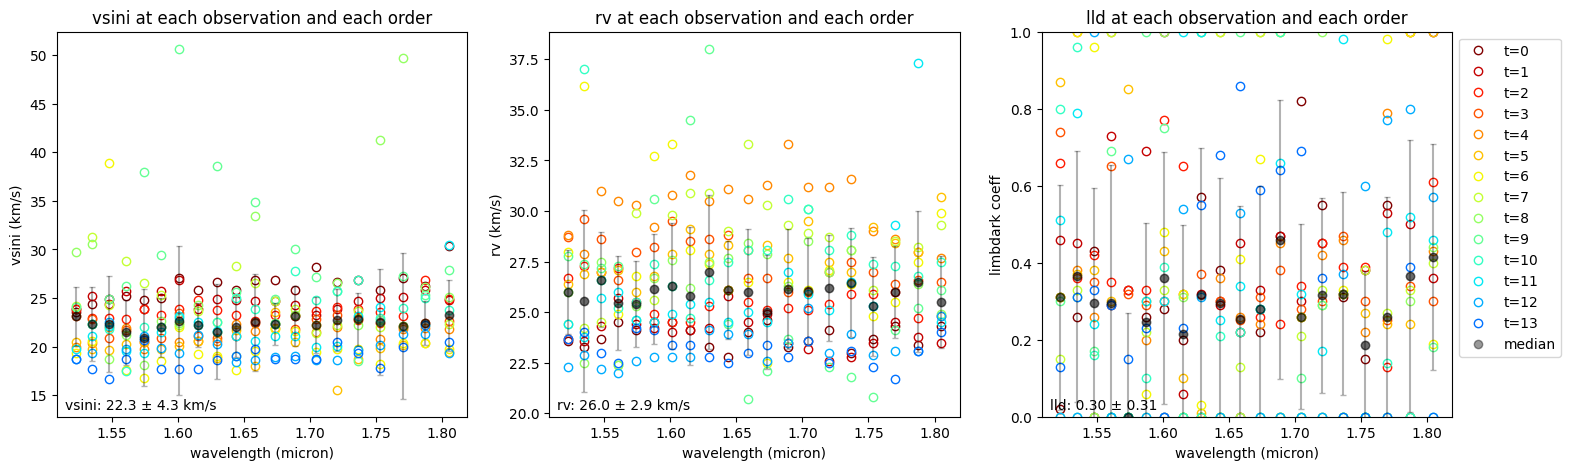

In [105]:
# Plot vsini and rv for bestfittin model - all
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
colors = [cm.jet_r(x) for x in np.linspace(0, 1, nobs+4)]
vsini_points = vsini_2d
rv_points = rv_2d
lld_points = lld_2d
lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl

for i, t in enumerate(indices):
    plt.plot(lam_points[:], vsini_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(vsini_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(vsini_points, axis=0), yerr=np.nanstd(vsini_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("vsini (km/s)")
plt.title("vsini at each observation and each order")
plt.text(0.02, 0.02, f"vsini: {np.nanmedian(vsini_points):.1f} ± {np.nanstd(vsini_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,2)
for i, t in enumerate(indices):
    plt.plot(lam_points, rv_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(rv_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(rv_points, axis=0), yerr=np.nanstd(rv_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("rv (km/s)")
plt.title("rv at each observation and each order")
plt.text(0.02, 0.02, f"rv: {np.nanmedian(rv_points):.1f} ± {np.nanstd(rv_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,3)
for i, t in enumerate(indices):
    plt.plot(lam_points, lld_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(lld_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(lld_points, axis=0), yerr=np.nanstd(lld_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("limbdark coeff")
plt.ylim(0, 1.)
plt.title("lld at each observation and each order")
plt.text(0.02, 0.02, f"lld: {np.nanmedian(lld_points):.2f} ± {np.nanstd(lld_points):.2f}", transform=plt.gca().transAxes)
plt.legend(loc=2, bbox_to_anchor=(1,1));

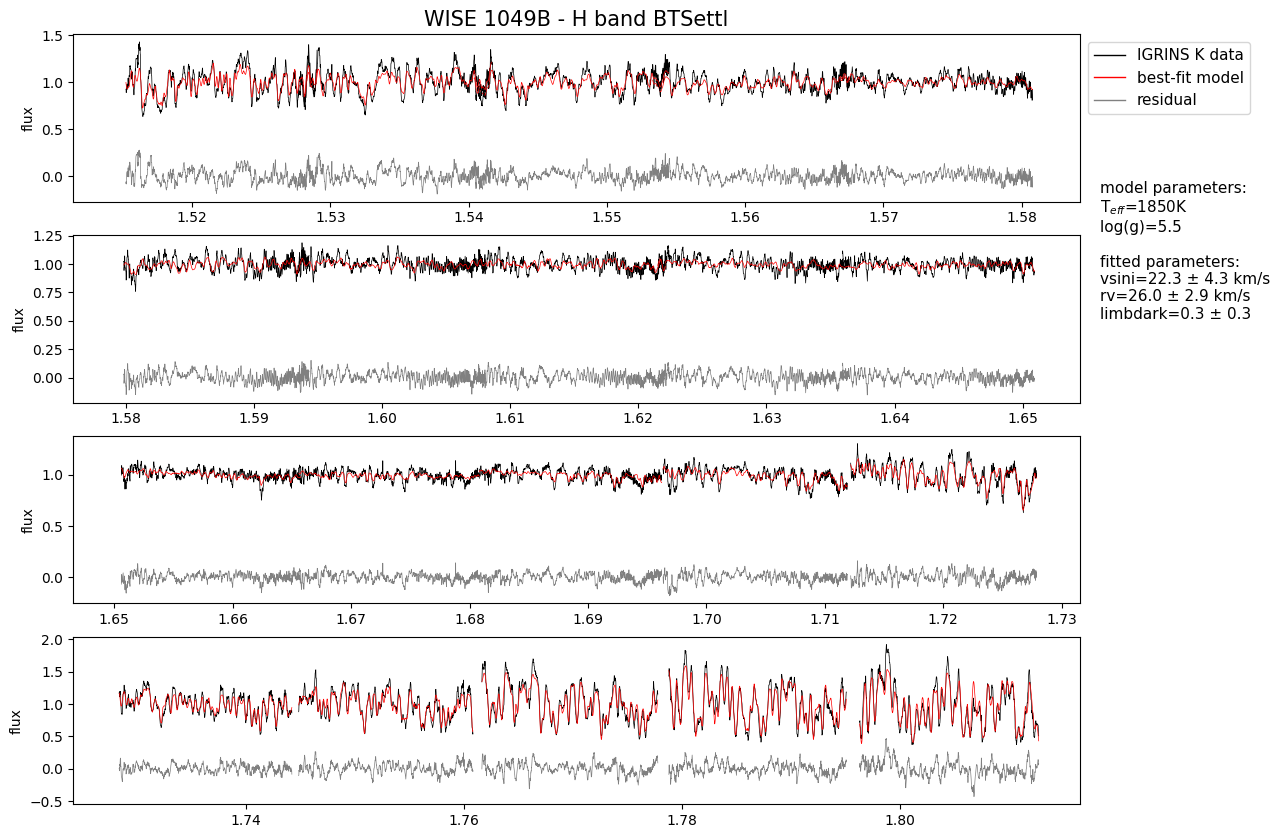

In [109]:
# plot best fitting spectrum
pad = 250
bfit_filename = f'IGRINS_W1049B_{band}_{model}.pickle'
with open(f"{datadir}/{bfit_filename}", 'rb') as f:
    ret = pickle.load(f, encoding="latin1")
fobs = ret['fobs0']
fobs = fobs[:20]
wobs = ret['wobs']
plt.figure(figsize=(13,10))
Teff = eval(model[3:8])*100
logg = model[9:12]

t=0
for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(chiplams[model][t,jj, pad:-pad], fobs[t,jj, pad:-pad], linewidth=0.5, color="black", label="observation")
        plt.plot(chiplams[model][t,jj, pad:-pad], fobs[t,jj,pad:-pad] - chipmods[model][t,jj,pad:-pad], linewidth=0.5, color="gray", label="residual")
        if jj in indices:
            plt.plot(chiplams[model][t,jj, pad:-pad], chipmods[model][t,jj, pad:-pad], linewidth=0.5, color="r", label="best-fit model")
        else:
            plt.plot(chiplams[model][t,jj, pad:-pad], chipmods[model][t,jj, pad:-pad], linewidth=0.5, color="r", label="discarded orders")
    plt.ylabel("flux")
    l, r = plt.xlim(chiplams[model][t,sub*5+4].min()-0.001, chiplams[model][t,sub*5].max()+0.001)
    #plt.ylim(-0.5,1.7)
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1, label="IGRINS K data"),
                        Line2D([0], [0], color="r", lw=1, label="best-fit model"),
                        Line2D([0], [0], color="grey", lw=1, label="residual"),
                        #Line2D([0], [0], color="magenta", lw=1, label="discarded orders"),
                        #Patch(facecolor='tab:blue', alpha=0.2, label="C14 CRIRES band")
                        ]
        plt.legend(handles=custom_lines, loc=2, bbox_to_anchor=(1,1), fontsize=11)

plt.title("WISE 1049B - H band BTSettl", fontsize=15)
plt.text(x=1.02, y=-0.7, s="model parameters: \nT$_{eff}$="+f"{Teff:.0f}K \nlog(g)={logg} \n"+ 
                        f"\nfitted parameters: \nvsini={np.nanmedian(vsini_2d)} ± {np.nanstd(vsini_2d):.1f} km/s" +
                        f"\nrv={np.nanmedian(rv_2d)} ± {np.nanstd(rv_2d):.1f} km/s" +
                        f"\nlimbdark={np.nanmedian(lld_2d):.1f} ± {np.nanstd(lld_2d):.1f}",
        fontsize=11, transform=plt.gca().transAxes);

### Binned Callie fits

In [2]:
datadir = f"{homedir}/uoedrive/result/Callie"
instru = "IGRINS"
target = "W1049B"
band = "H"
tag = "bounds"

In [3]:
nobs = 14
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
lld = {}
wcoef = {}
modellist = []
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_chipmods_*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    modellist.append(modelname)
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_chiplams_*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
for f in sorted(glob.glob(f"{datadir}/{instru}_{target}_{band}_{tag}_*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']
    lld[modelname] = results['lld']
chisq.keys()

dict_keys(['t1400g1000f4', 't1400g1000f8', 't1500g1000f4', 't1500g1000f8'])

In [47]:
results['ccoef'][0]

'-0.01906389486691356, 1.1246043673718789'

In [4]:
# find best fitting model
df = pd.DataFrame({
    'model name':[model for model in modellist], 
    'median':[np.median(chisq[model]) for model in modellist], 
    'mean':[np.mean(chisq[model]) for model in modellist], 
    'min':[np.min(chisq[model]) for model in modellist]
})
df = df.sort_values(by=['median'])
df.style.format({'median': '{:.0f}'.format, 'mean': '{:.0f}'.format,'min': '{:.0f}'.format,}).hide(axis="index")

model name,median,mean,min
t1400g1000f8,13279377940,16416522437,11749
t1400g1000f4,14458047438,26046563274,8891
t1500g1000f8,14874962945,17669464314,11008
t1500g1000f4,17119407994,32405068987,10978


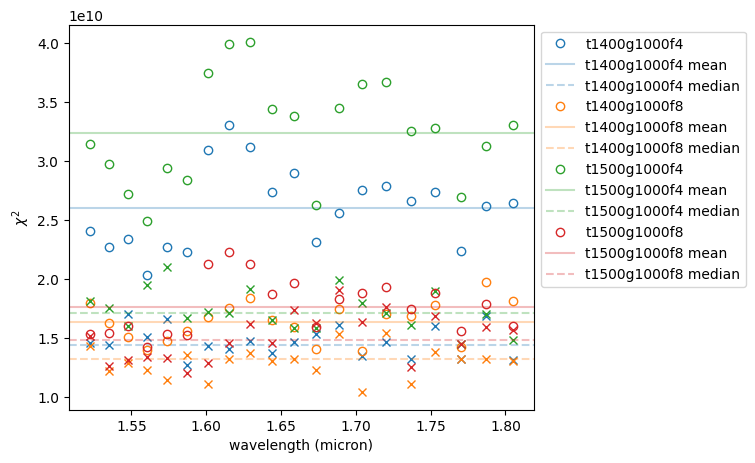

In [5]:
plt.figure(figsize=(6,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lam_points = np.median(np.median(chiplams[modellist[0]], axis=0), axis=1)
for i, key in enumerate(chisq.keys()):
    plt.plot(lam_points, np.mean(chisq[key].reshape(14, 20), axis=0), "o", mfc="none", color=colors[i], label=f"{key}")
    plt.plot(lam_points, np.median(chisq[key].reshape(14, 20), axis=0), "x", mfc="none", color=colors[i])
    plt.axhline(np.mean(chisq[key]), color=colors[i], alpha=0.3, label=f"{key} mean")
    plt.axhline(np.median(chisq[key]), ls="--", color=colors[i], alpha=0.3, label=f"{key} median")
plt.ylabel("$\chi ^2$")
plt.xlabel("wavelength (micron)")
plt.legend(bbox_to_anchor=(1,1));

In [6]:
model = 't1400g1000f8'
vsini_2d = np.array(np.around(vsini[model].reshape((nobs, 20)), 1))
rv_2d = np.array(np.around(rv[model].reshape((nobs, 20)) * c, 1))
lld_2d = np.array(np.around(lld[model].reshape((nobs, 20)), 2))

#remove outliers
thres = 1.5
print("vsini outliers:", vsini_2d[np.abs(stats.zscore(vsini_2d, axis=None)) > thres])
vsini_2d[np.abs(stats.zscore(vsini_2d, axis=None)) > thres] = np.nan
print("rv outliers:", rv_2d[np.abs(stats.zscore(rv_2d, axis=None)) > thres])
rv_2d[np.abs(stats.zscore(rv_2d, axis=None)) > thres] = np.nan
print("lld outliers:", lld_2d[np.abs(stats.zscore(lld_2d, axis=None)) > thres])
lld_2d[np.abs(stats.zscore(lld_2d, axis=None)) > thres] = np.nan

indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
indices_masked = [0,1,2,3,4,9,10,11,12,13]

masked_vsini = vsini_2d[indices_masked,:]
masked_rv = rv_2d[indices_masked,:]
masked_lld = lld_2d[indices_masked,:]

for i, jj in enumerate(range(20)):
    print(f"order {jj}\
    vsini: {np.nanmedian(vsini_2d[:,i]):.1f} ± {np.nanstd(vsini_2d[:,i]):.1f} km/s\
    rv: {np.nanmedian(rv_2d[:,i]):.1f} ± {np.nanstd(rv_2d[:,i]):.1f} km/s\
    lld: {np.nanmedian(lld_2d[:,i]):.2f} ± {np.nanstd(lld_2d[:,i]):.2f}")

print(f"all orders: \
    vsini: {np.nanmedian(vsini_2d):.1f} ± {np.nanstd(vsini_2d):.1f}\
    rv: {np.nanmedian(rv_2d):.1f} ± {np.nanstd(rv_2d):.1f}\
    lld: {np.nanmedian(lld_2d):.2f} ± {np.nanstd(lld_2d):.2f}")

print(f"all orders w/o bad t:\
    vsini: {np.nanmedian(masked_vsini):.1f} ± {np.nanstd(masked_vsini):.1f}\
    rv: {np.nanmedian(masked_rv):.1f} ± {np.nanstd(masked_rv):.1f}\
    lld: {np.nanmedian(masked_lld):.2f} ± {np.nanstd(masked_lld):.2f}")

vsini outliers: [ 96.4  97.2 100.  100.  100.  100.  100.  100.  100.  100.  100.   99.5
 100.   92.8  99.8  88.7 100.  100.  100.  100.   98.1 100.  100.  100.
 100.  100.  100.  100.  100.   93.9 100.  100.  100.  100.  100.   99.8
 100.  100.   97.2 100.   97.1 100.  100.  100.  100.  100. ]
rv outliers: [-31.9  58.8 -34.8  45.2  72.4  60.5 -26.5 -35.5 -21.  -17.4 -44.   -8.2
 -46.8 -14.1 -43.3  -6.5 -11.9 -32.6 -37.1 -39.9  40.5 -12.9]
lld outliers: []
order 0    vsini: 32.0 ± 12.3 km/s    rv: 20.7 ± 2.9 km/s    lld: 0.60 ± 0.39
order 1    vsini: 30.7 ± 13.3 km/s    rv: 21.0 ± 3.2 km/s    lld: 0.73 ± 0.44
order 2    vsini: 30.4 ± 8.4 km/s    rv: 21.5 ± 3.0 km/s    lld: 0.68 ± 0.35
order 3    vsini: 30.7 ± 8.3 km/s    rv: 21.6 ± 4.9 km/s    lld: 0.23 ± 0.45
order 4    vsini: 31.5 ± 10.1 km/s    rv: 21.4 ± 3.8 km/s    lld: 0.39 ± 0.37
order 5    vsini: 31.2 ± 14.1 km/s    rv: 21.0 ± 3.1 km/s    lld: 0.66 ± 0.42
order 6    vsini: 29.7 ± 7.3 km/s    rv: 21.5 ± 6.6 km/s    lld: 0.42 ± 0

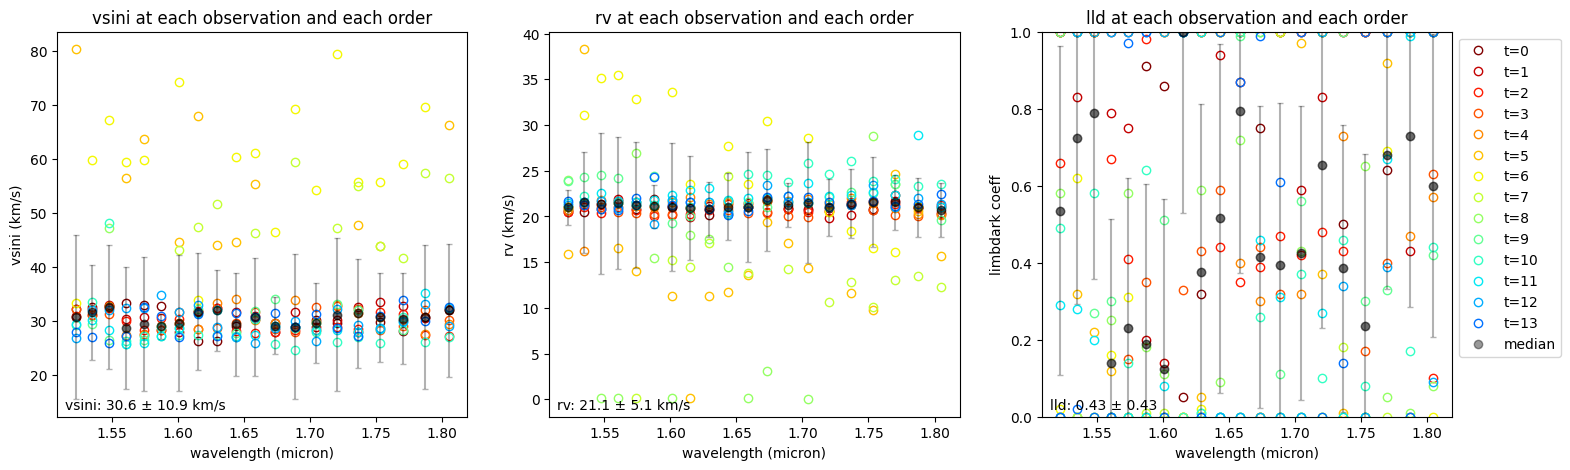

In [6]:
# Plot vsini and rv for bestfittin model - all
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
colors = [cm.jet_r(x) for x in np.linspace(0, 1, nobs+4)]
vsini_points = vsini_2d
rv_points = rv_2d
lld_points = lld_2d
lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl

for i, t in enumerate(indices):
    plt.plot(lam_points[:], vsini_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(vsini_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(vsini_points, axis=0), yerr=np.nanstd(vsini_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("vsini (km/s)")
plt.title("vsini at each observation and each order")
plt.text(0.02, 0.02, f"vsini: {np.nanmedian(vsini_points):.1f} ± {np.nanstd(vsini_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,2)
for i, t in enumerate(indices):
    plt.plot(lam_points, rv_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(rv_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(rv_points, axis=0), yerr=np.nanstd(rv_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("rv (km/s)")
plt.title("rv at each observation and each order")
plt.text(0.02, 0.02, f"rv: {np.nanmedian(rv_points):.1f} ± {np.nanstd(rv_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,3)
for i, t in enumerate(indices):
    plt.plot(lam_points, lld_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(lld_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(lld_points, axis=0), yerr=np.nanstd(lld_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("limbdark coeff")
plt.ylim(0, 1.)
plt.title("lld at each observation and each order")
plt.text(0.02, 0.02, f"lld: {np.nanmedian(lld_points):.2f} ± {np.nanstd(lld_points):.2f}", transform=plt.gca().transAxes)
plt.legend(loc=2, bbox_to_anchor=(1,1));

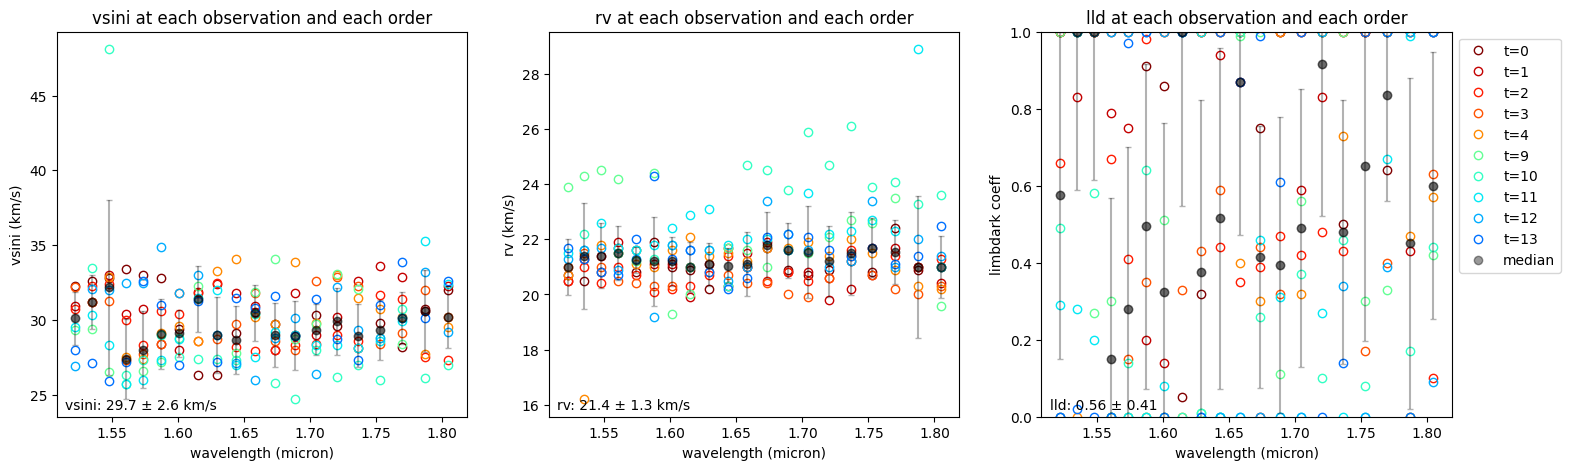

In [7]:
# Plot vsini and rv for bestfittin model
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
colors = [cm.jet_r(x) for x in np.linspace(0, 1, nobs+4)]
vsini_points = masked_vsini
rv_points = masked_rv
lld_points = masked_lld
lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl

for i, t in enumerate(indices_masked):
    plt.plot(lam_points[:], vsini_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(vsini_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(vsini_points, axis=0), yerr=np.nanstd(vsini_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("vsini (km/s)")
plt.title("vsini at each observation and each order")
plt.text(0.02, 0.02, f"vsini: {np.nanmedian(vsini_points):.1f} ± {np.nanstd(vsini_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,2)
for i, t in enumerate(indices_masked):
    plt.plot(lam_points, rv_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(rv_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(rv_points, axis=0), yerr=np.nanstd(rv_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("rv (km/s)")
plt.title("rv at each observation and each order")
plt.text(0.02, 0.02, f"rv: {np.nanmedian(rv_points):.1f} ± {np.nanstd(rv_points):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(1,3,3)
for i, t in enumerate(indices_masked):
    plt.plot(lam_points, lld_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(lld_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(lld_points, axis=0), yerr=np.nanstd(lld_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("limbdark coeff")
plt.ylim(0, 1.)
plt.title("lld at each observation and each order")
plt.text(0.02, 0.02, f"lld: {np.nanmedian(lld_points):.2f} ± {np.nanstd(lld_points):.2f}", transform=plt.gca().transAxes)
plt.legend(loc=2, bbox_to_anchor=(1,1));

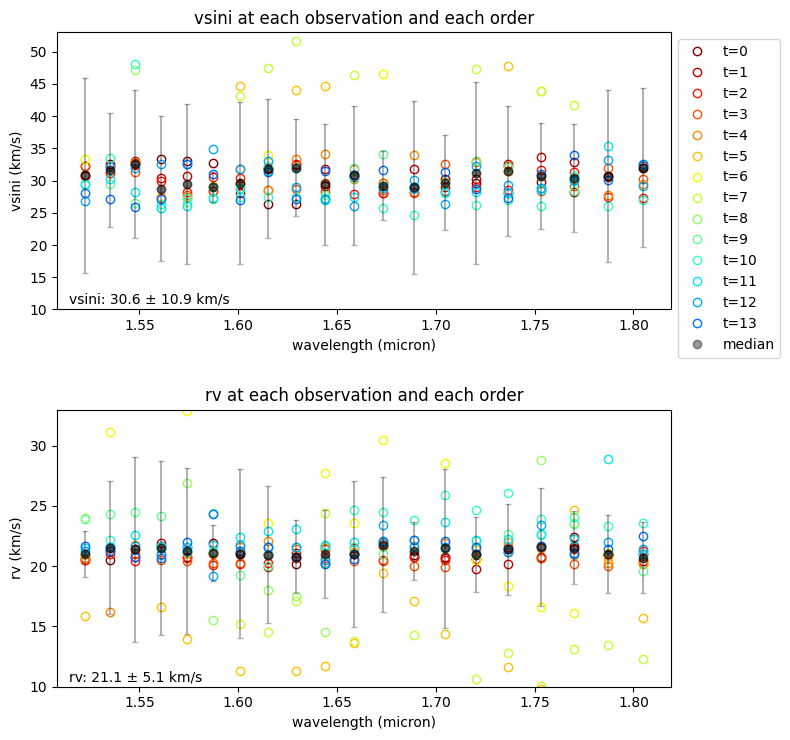

In [8]:
# Plot vsini and rv for bestfittin model - all
plt.figure(figsize=(8,7.5))
plt.subplot(2,1,1)
colors = [cm.jet_r(x) for x in np.linspace(0, 1, nobs+4)]
vsini_points = vsini_2d
rv_points = rv_2d
lld_points = lld_2d
lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl

for i, t in enumerate(indices):
    plt.plot(lam_points[:], vsini_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(vsini_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(vsini_points, axis=0), yerr=np.nanstd(vsini_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("vsini (km/s)")
plt.ylim(10,53)
plt.title("vsini at each observation and each order")
plt.text(0.02, 0.02, f"vsini: {np.nanmedian(vsini_points):.1f} ± {np.nanstd(vsini_points):.1f} km/s", transform=plt.gca().transAxes)
plt.legend(loc=2, bbox_to_anchor=(1,1));

plt.subplot(2,1,2)
for i, t in enumerate(indices):
    plt.plot(lam_points, rv_points[i], "o", mfc="none", color=colors[t], label=f't={t}')
plt.plot(lam_points, np.nanmedian(rv_points, axis=0), "o", label="median", color="k", alpha=0.4)
plt.errorbar(lam_points, np.nanmedian(rv_points, axis=0), yerr=np.nanstd(rv_points, axis=0), 
             marker="o", color="k", alpha=0.3, ls="none", capsize=2)
plt.xlabel("wavelength (micron)")
plt.ylabel("rv (km/s)")
plt.ylim(10,33)
plt.title("rv at each observation and each order")
plt.text(0.02, 0.02, f"rv: {np.nanmedian(rv_points):.1f} ± {np.nanstd(rv_points):.1f} km/s", transform=plt.gca().transAxes)

plt.tight_layout()

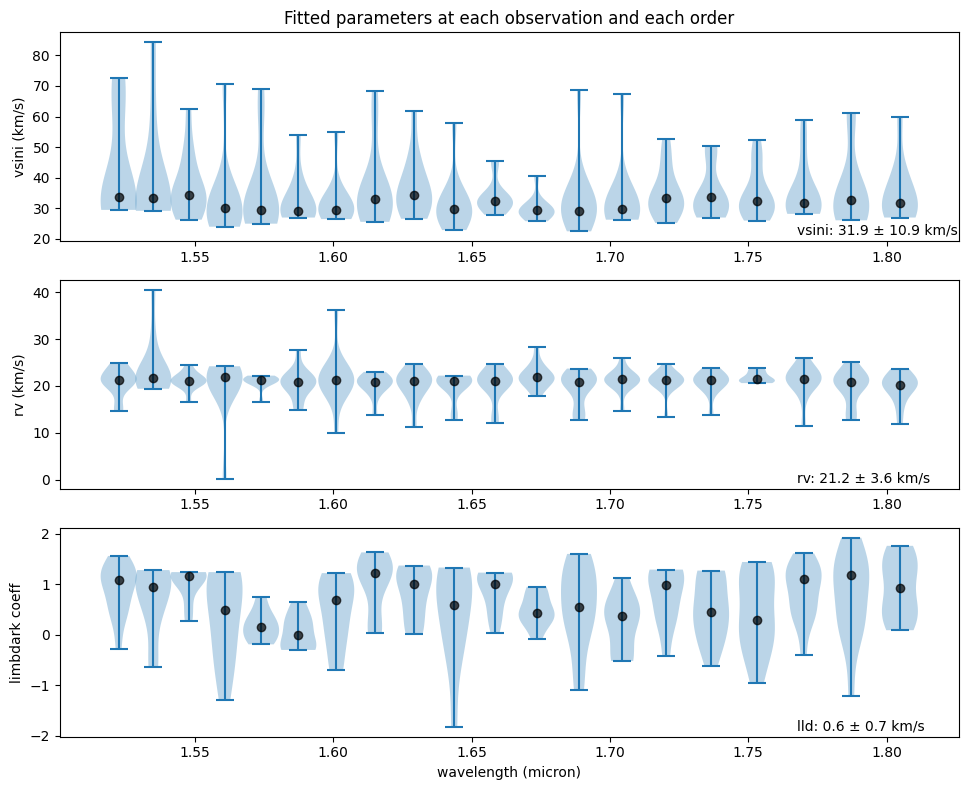

In [85]:
def filtnan(data):
    mask = ~np.isnan(data)
    return [d[m] for d, m in zip(data.T, mask.T)]
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
width = 0.013
plt.violinplot(filtnan(vsini_2d), positions=lam_points, widths=width)
plt.plot(lam_points, np.nanmedian(vsini_2d, axis=0), "o", label="median", color="k", alpha=0.7)
plt.ylabel("vsini (km/s)")
plt.title("Fitted parameters at each observation and each order")
plt.text(0.82, 0.03, f"vsini: {np.nanmedian(vsini_2d)} ± {np.nanstd(vsini_2d):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(3,1,2)
plt.violinplot(filtnan(rv_2d), positions=lam_points, widths=width)
plt.plot(lam_points, np.nanmedian(rv_2d, axis=0), "o", label="median", color="k", alpha=0.7)
plt.ylabel("rv (km/s)")
plt.text(0.82, 0.03, f"rv: {np.nanmedian(rv_2d)} ± {np.nanstd(rv_2d):.1f} km/s", transform=plt.gca().transAxes)

plt.subplot(3,1,3)
plt.violinplot(filtnan(lld_2d), positions=lam_points, widths=width)
plt.plot(lam_points, np.nanmedian(lld_2d, axis=0), "o", label="median", color="k", alpha=0.7)
plt.xlabel("wavelength (micron)")
plt.ylabel("limbdark coeff")
plt.text(0.82, 0.03, f"lld: {np.nanmedian(lld_2d):.1f} ± {np.nanstd(lld_2d):.1f} km/s", transform=plt.gca().transAxes)

plt.tight_layout()

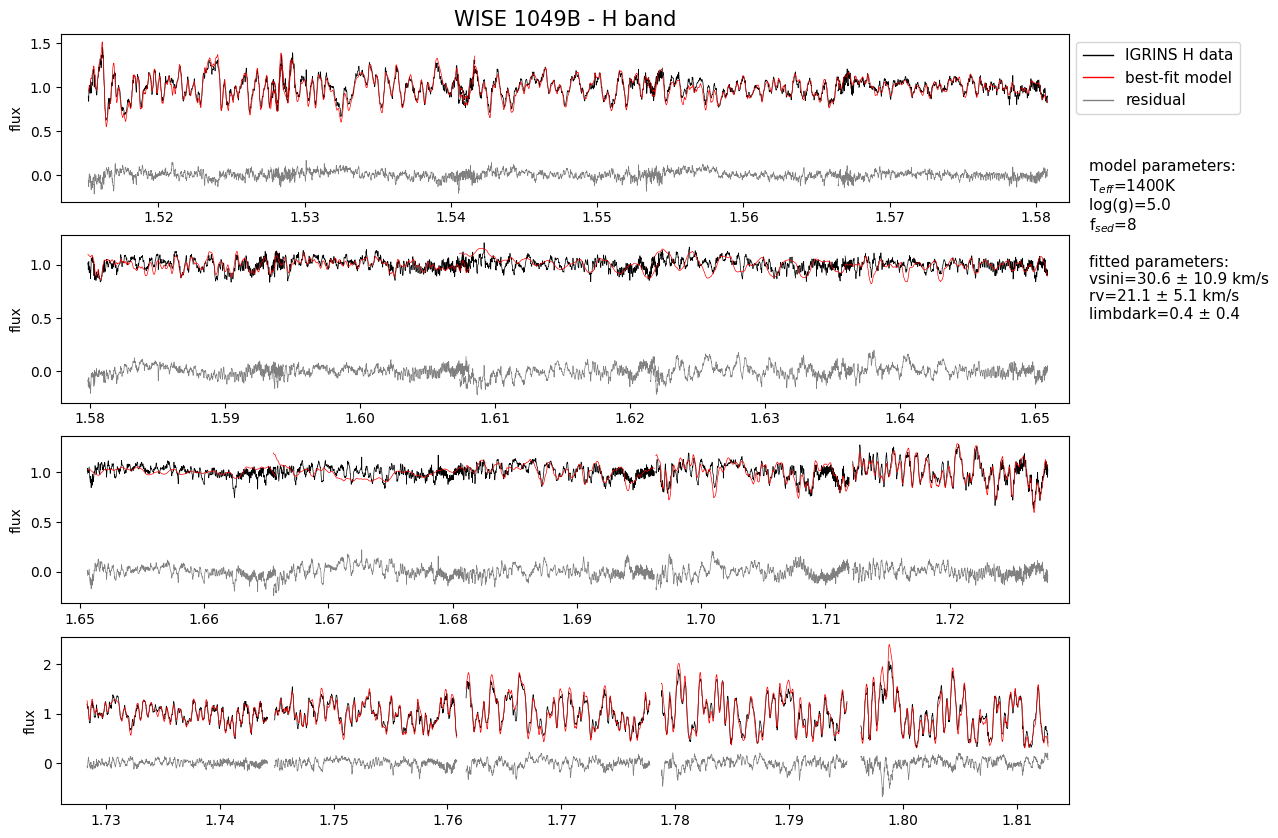

In [16]:
# plot best fitting spectrum
pad = 250
bfit_filename = f'IGRINS_W1049B_{band}_{model}.pickle'
with open(f"{datadir}/{bfit_filename}", 'rb') as f:
    ret = pickle.load(f, encoding="latin1")
fobs = ret['fobs0']
fobs = fobs[:20]
wobs = ret['wobs']
Teff = eval(model[1:5])
logg = 5.0
plt.figure(figsize=(13,10))

t=5
for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(chiplams[model][t,jj, pad:-pad], fobs[t,jj, pad:-pad], linewidth=0.5, color="black", label="observation")
        plt.plot(chiplams[model][t,jj, pad:-pad], fobs[t,jj,pad:-pad] - chipmods[model][t,jj,pad:-pad], linewidth=0.5, color="gray", label="residual")
        if jj in indices:
            plt.plot(chiplams[model][t,jj, pad:-pad], chipmods[model][t,jj, pad:-pad], linewidth=0.5, color="r", label="best-fit model")
        else:
            plt.plot(chiplams[model][t,jj, pad:-pad], chipmods[model][t,jj, pad:-pad], linewidth=0.5, color="r", label="discarded orders")
    plt.ylabel("flux")
    l, r = plt.xlim(chiplams[model][t,sub*5+4].min()+0.001, chiplams[model][t,sub*5].max()-0.001)
    #plt.ylim(-0.5,1.7)
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1, label="IGRINS H data"),
                        Line2D([0], [0], color="r", lw=1, label="best-fit model"),
                        Line2D([0], [0], color="grey", lw=1, label="residual"),
                        #Line2D([0], [0], color="magenta", lw=1, label="discarded orders"),
                        #Patch(facecolor='tab:blue', alpha=0.2, label="C14 CRIRES band")
                        ]
        plt.legend(handles=custom_lines, loc=2, bbox_to_anchor=(1,1), fontsize=11)

plt.title("WISE 1049B - H band", fontsize=15)
plt.text(x=1.02, y=-0.7, s="model parameters: \nT$_{eff}$="+f"{Teff:.0f}K \nlog(g)={logg} \n"+"f$_{sed}$=8\n" + 
                        f"\nfitted parameters: \nvsini={np.nanmedian(vsini_2d):.1f} ± {np.nanstd(vsini_2d):.1f} km/s" +
                        f"\nrv={np.nanmedian(rv_2d):.1f} ± {np.nanstd(rv_2d):.1f} km/s" +
                        f"\nlimbdark={np.nanmedian(lld_2d):.1f} ± {np.nanstd(lld_2d):.1f}",
        fontsize=11, transform=plt.gca().transAxes)
plt.savefig(f"{homedir}/uoedrive/result/paper1/specH.png", transparent=True, dpi=200, bbox_inches="tight")

In [30]:
22.23/c

7.415141164540749e-05